In [2]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

# ---- My utils ----
from models import *
from utils.train_arguments import *
from utils.utils_data import *
from utils.utils_training import *

In [3]:
args.img_size = 256
args.crop_size = 224
args.data_augmentation = True
args.pretrained = True
args.validation_size = 0.15
args.binary_problem = True

In [ ]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [4]:
if args.data_augmentation:
    train_aug = [
        transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
        transforms.Resize((args.img_size, args.img_size)),
        transforms.RandomCrop((args.crop_size, args.crop_size)),
        transforms.RandomHorizontalFlip(0.5),  # because this method is used for PIL Image dtype
        transforms.RandomVerticalFlip(0.5),  # because this method is used for PIL Image dtype
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.ToTensor(),  # because inpus dtype is PIL Image
    ]
else:
    train_aug = [
        transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
        transforms.Resize((args.img_size, args.img_size)),
        transforms.CenterCrop((args.crop_size, args.crop_size)),
        transforms.ToTensor(),  # because inpus dtype is PIL Image
    ]

val_aug = [
    transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
    transforms.Resize((args.img_size, args.img_size)),
    transforms.CenterCrop((args.crop_size, args.crop_size)),
    transforms.ToTensor(),  # because inpus dtype is PIL Image
]

if args.pretrained:
    train_aug.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    val_aug.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))

# data_partition='', data_augmentation=None, validation_size=0.15, seed=42
train_dataset = SIMEPU_Dataset(data_partition='train', transform=transforms.Compose(train_aug), validation_size=args.validation_size, binary_problem=args.binary_problem)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=True)

val_dataset = SIMEPU_Dataset(data_partition='validation', transform=transforms.Compose(val_aug), validation_size=args.validation_size, binary_problem=args.binary_problem)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=False)

In [5]:
args.model_name = "resnet34"

In [6]:
model = model_selector(args.model_name, num_classes=train_dataset.num_classes, pretrained=args.pretrained)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

Pretrained-> Remember at end: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm

In [7]:
model.load_state_dict(torch.load("results/resnet34_adam_256to224_lr0.0001_DA_pretrained_Binary/model_best_accuracy.pt"))

<All keys matched successfully>

----------------------------------------------------------------------------------------------------------

In [58]:
model.eval()
correct, total = 0, 0
list_outputs, list_targets = [], []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        list_outputs.append(outputs)
        outputs = (nn.Sigmoid()(outputs)>0.5).float()
        targets = targets.unsqueeze(1).type_as(outputs)
        list_targets.append(targets)

        total += targets.size(0)
        correct += (outputs == targets).float().sum().item()
print("Accuracy: {:.2f}%".format(100. * correct / total))

Accuracy: 97.79%


In [10]:
outs = nn.Sigmoid()(torch.cat(list_outputs))
labels = torch.cat(list_targets)
print("Outs shape: {}".format(outs.shape))
print("Labels shape: {}".format(labels.shape))

Outs shape: torch.Size([6709, 1])
Labels shape: torch.Size([6709, 1])


In [11]:
# No Daño clase 0 / Daño clase 1
true_positives, false_positives = [], []
for umbral in np.unique(outs.data.cpu().numpy()):
    
    # Los verdadderos son aquellos que tienen daño y son clasificados como que tienen (correctamente)
    true_positives.append( int((outs[labels==1] > umbral).float().sum().item()) / len(outs[labels==1]) )
    
    # Los falsos positivos son aquellos No daño que tienen un valor mayor stricto que el umbral
    # Positivos que deberian haber sido negativos (por eso falsos) porque se trata de No Daño!
    false_positives.append( int((outs[labels==0] > umbral).float().sum().item()) / len(outs[labels==0]) )

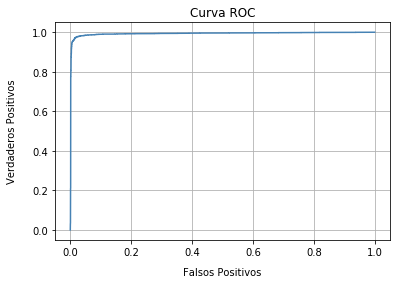

In [57]:
# Vamos a visualizar los resultados obtenidos
plt.plot(false_positives, true_positives, 'steelblue')

plt.title("Curva ROC")
plt.ylabel("Verdaderos Positivos", labelpad=15)
plt.xlabel("Falsos Positivos", labelpad=10)

plt.grid()
#plt.savefig('curva_ROC.eps', bbox_inches = 'tight')

In [15]:
def H(clientes, impostores):
    """
    Se itera sobre los escores de clientes e impostores y vamos sumando
        1 si c>i
        0.5 si c==i
        0 si i>c
    """
    compt_sum = 0
    for c in clientes:
        for i in impostores:
            if c>i:
                compt_sum+=1
            elif c==i:
                compt_sum+=0.5
    return compt_sum

In [16]:
# Recuperamos los puntos que forman la curva ROC de los diferentes supuestos
def aroc(clientes, impostores):
    return 1/(len(clientes)*len(impostores)) * H(clientes, impostores)

In [49]:
print("Area bajo curva ROC: {:.4f}".format(aroc( outs[labels==1].data.cpu().numpy(), outs[labels==0].data.cpu().numpy() )))

Area bajo curva ROC: 0.9932


----------------------------------------------------------------------------------------------------------

In [18]:
from sklearn import metrics

In [26]:
outs_np = outs.data.cpu().numpy()
labels_np = labels.data.cpu().numpy()

In [46]:
fpr, tpr, thresholds = metrics.roc_curve(labels_np, outs_np, pos_label=1)

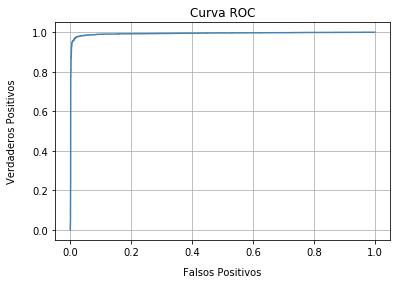

In [56]:
# Vamos a visualizar los resultados obtenidos
plt.plot(fpr.tolist(), tpr.tolist(), 'steelblue')

plt.title("Curva ROC")
plt.ylabel("Verdaderos Positivos", labelpad=15)
plt.xlabel("Falsos Positivos", labelpad=10)

plt.grid()
#plt.savefig('curva_ROC.eps', bbox_inches = 'tight')

In [50]:
print("Area bajo curva ROC: {:.4f}".format(metrics.auc(fpr, tpr)))

Area bajo curva ROC: 0.9932


----------------------------------------------------------------------------------------------------------

In [125]:
# Calcular el valor aproximado de Verdaderos positivos dado ratio de Falsos Positivos
def TPwithFP(tp_rates, fp_rates, fp_ratio, return_dist=False):
    res, dist = 0, 99999
    
    index_sort_fp = np.argsort(fp_rates)
    fp_rate_sorted = fp_rates[index_sort_fp]
    
    for idx, val in enumerate(fp_rate_sorted):
        if abs(val-fp_ratio)<dist:
            res = idx
            dist = abs(val-fp_ratio)
            
        if abs(val-fp_ratio)>dist: # Al estar ordenado, si nos distanciamos debemos parar
            break
        
    if return_dist: return res, dist
    return tp_rates[index_sort_fp][res]

In [128]:
TPwithFP(tpr, fpr, 0.001)

0.38235294117647056

In [129]:
TPwithFP(np.array(true_positives), np.array(false_positives), 0.001)

0.38923654568210264